# Community detection

Classical algorithm used as a model: https://en.wikipedia.org/wiki/Louvain_method. Task is to minimize funcion $Q=\dfrac{1}{2m} \sum_{ij}(-A_{ij}+\dfrac{k_ik_j}{2m}) \delta(c_i,c_j)$.

Algorithm solves community detection problem of undirected graph $G = (V, E)$ where every edge there has weight $w_{xy}$.

QUBO elements $|V||C|$ where $C$ is set of communities. Maximum number of communities must be defined a priori. Constraints:
1. Vertex can belong to only one community 
2. Minimize above mentioned function. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
import dwave.inspector
import networkx as nx
from networkx.classes.function import path_weight

## QUBO function

In [2]:
def create_qubo(G, communities, p):
    vertices = len(G.nodes)
    Q = np.zeros((vertices*communities, vertices*communities))
    
    # We need helper datastructure to containt k
    k = np.zeros(vertices)
    for e in G.edges:
        k[e[0]] += G[e[0]][e[1]]['weight']
        k[e[1]] += G[e[0]][e[1]]['weight']

    # Constraint 1
    for v in range(vertices): 
        for c1 in range(communities): 
            for c2 in range(c1+1,communities): 
                Q[v*communities+c1,v*communities+c2]=p
                
    # Constraint 2 and 3
    for v1 in range(vertices): 
        for v2 in range(v1+1,vertices): 
            for c in range(communities):
                Q[v1*communities+c, v2*communities+c] = round(k[v1]*k[v2] / (2*p),1)
                
    for e in G.edges:
        for c in range(communities):
            Q[e[0]*communities+c, e[1]*communities+c] -= G[e[0]][e[1]]['weight']
            
    return Q

## Helper functions

In [3]:
def print_graph(G, node_color=None):
    pos = nx.get_node_attributes(G, 'pos')
    m = 0
    for k,v in nx.get_edge_attributes(G, 'weight').items():
        m = max(m,v)
    a = [v/m for k,v in nx.get_edge_attributes(G, 'weight').items()]
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_edges(G, pos, alpha=a)
    nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_color)
    plt.axis("off")
    plt.show()
    
colors=['blue','red','green','magenta', 'black']

def result_to_colors(sample):
    cs = np.zeros(len(G.nodes))
    for k,v in sample.items():
        if v==1: 
            cs[k[0]]=k[1]
    nc = []
    for i in range(len(cs)):
        nc.append(colors[int(cs[i])])
    return nc


## Small example

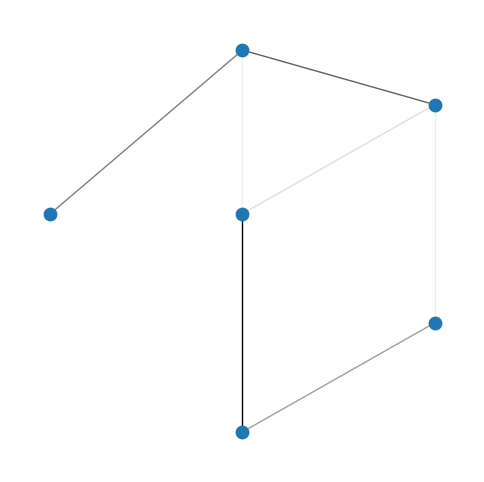

In [4]:
def simple_graph():
    E = np.array([(0, 2, 1), (1, 2, 2), (1, 3, 1), (0, 5, 8), (0, 1, 10), (3, 4, 6), (2, 4, 16)])
    V = [(0,dict(pos=(0.5,0.8))), (1,dict(pos=(0.8,0.7))), (2,dict(pos=(0.5,0.5))), (3,dict(pos=(0.8,0.3))), (4,dict(pos=(0.5,0.1))), (5,dict(pos=(0.2,0.5)))]
    G = nx.Graph()
    G.add_nodes_from(V)
    for e in E:
        G.add_edge(e[0], e[1], weight=e[2])
    return G

G = simple_graph()
communities = 3
print_graph(G)

![](graph1.png)

In [5]:
max_count = 0
for e in G.edges:
    max_count += G[e[0]][e[1]]['weight']
print('Max count:',max_count)

labels = {}
for i in range(len(G.nodes)):
    for j in range(communities):
        labels[i*communities + j]=(i,j)

Max count: 44


### Create QUBO and BQM

In [6]:
ts = time.time()
Q = create_qubo(G, communities, max_count)
qubo_time = (time.time()-ts)*1000
print('Time used for construction Q (ms): {:.3f}\n'.format(qubo_time))

ts = time.time()
bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
bqm_time = (time.time()-ts)*1000
bqm = bqm.relabel_variables(labels, inplace=False)

Time used for construction Q (ms): 0.419



### Exact solver

In [7]:
ts = time.time()
sampleset = dimod.ExactSolver().sample(bqm)
det_time = (time.time()-ts)*1000
print('Time used (ms): {:.3f}\n'.format(det_time))
energy = sampleset.first.energy
print(sampleset.truncate(20))

Time used (ms): 348.467

   (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) ... (5, 2) energy num_oc.
0       1      0      0      1      0      0      0 ...      0  -26.2       1
1       0      0      1      0      0      1      1 ...      1  -26.2       1
2       0      1      0      0      1      0      1 ...      0  -26.2       1
3       0      0      1      0      0      1      0 ...      1  -26.2       1
4       0      1      0      0      1      0      0 ...      0  -26.2       1
5       1      0      0      1      0      0      0 ...      0  -26.2       1
6       0      1      0      0      1      0      1 ...      0  -23.5       1
7       0      0      1      0      0      1      1 ...      1  -23.5       1
8       0      0      1      0      0      1      1 ...      1  -23.5       1
9       1      0      0      1      0      0      0 ...      0  -23.5       1
10      0      1      0      0      1      0      0 ...      0  -23.5       1
11      0      0      1      0      0  

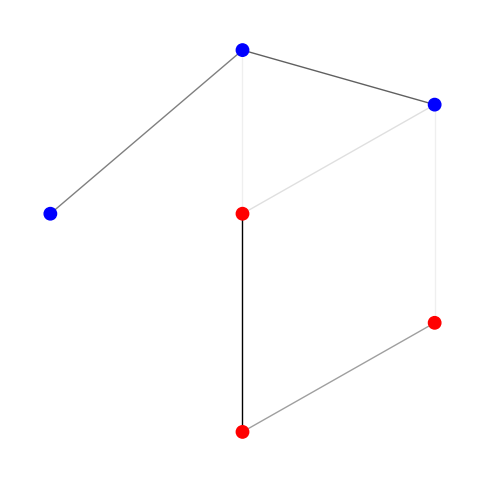

In [8]:
nc = result_to_colors(sampleset.first.sample)
print_graph(G, node_color=nc)

## More complex matric

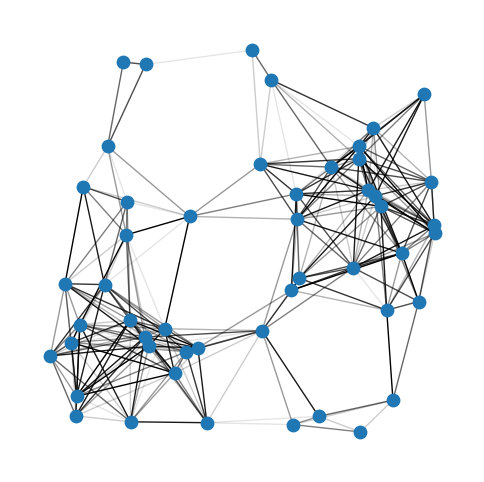

In [9]:
seed = 42
max_weight = 10
random.seed(seed)
G = nx.random_geometric_graph(50, 0.3, seed=seed)
nx.set_edge_attributes(G, {e: {'weight': random.randint(1, max_weight)} for e in G.edges})

print_graph(G)

In [10]:
max_count = 0
for e in G.edges:
    max_count += G[e[0]][e[1]]['weight']
print('Max count:',max_count)

labels = {}
for i in range(len(G.nodes)):
    for j in range(communities):
        labels[i*communities + j]=(i,j)

Max count: 1475


### Create QUBO and BQM

In [11]:
ts = time.time()
Q = create_qubo(G, communities, max_count)
qubo_time = (time.time()-ts)*1000
print('Time used for construction Q (ms): {:.3f}\n'.format(qubo_time))

ts = time.time()
bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
bqm_time = (time.time()-ts)*1000
bqm = bqm.relabel_variables(labels, inplace=False)

Time used for construction Q (ms): 20.296



### Heuristic solver

In [12]:
num_reads = 1000
ts = time.time()
sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=num_reads)
det_time = (time.time()-ts)*1000
print('Time used (ms): {:.3f}\n'.format(det_time))
energy = sampleset.first.energy
print(sampleset.truncate(20))

Time used (ms): 3055.238

   (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) ... (49, 2) energy num_oc.
0       0      1      0      1      0      0      0 ...       1 -762.6       1
1       0      1      0      1      0      0      0 ...       1 -762.6       1
2       0      0      1      0      1      0      1 ...       0 -762.6       1
3       1      0      0      0      0      1      0 ...       0 -762.6       1
4       0      0      1      0      1      0      1 ...       0 -762.6       1
5       1      0      0      0      1      0      0 ...       1 -762.6       1
6       1      0      0      0      1      0      0 ...       1 -762.6       1
7       0      0      1      0      1      0      1 ...       0 -762.6       1
8       1      0      0      0      1      0      0 ...       1 -762.6       1
9       0      0      1      0      1      0      1 ...       0 -762.6       1
10      0      0      1      0      1      0      1 ...       0 -762.6       1
11      1      0      0   

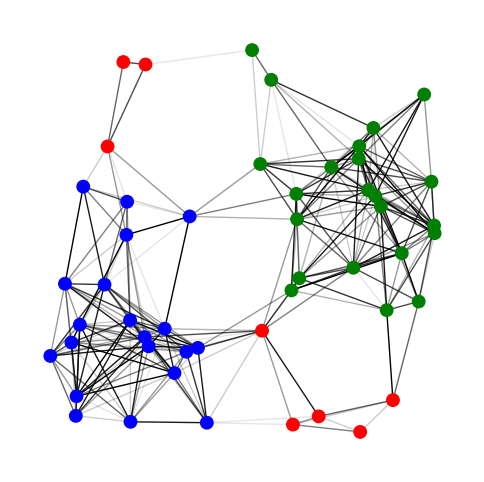

In [13]:
nc = result_to_colors(sampleset.first.sample)
print_graph(G, node_color=nc)

In [14]:
def solve_random_graph(seed):
    max_weight = 10
    random.seed(seed)
    G = nx.random_geometric_graph(50, 0.3, seed=seed)
    nx.set_edge_attributes(G, {e: {'weight': random.randint(1, max_weight)} for e in G.edges})
    print_graph(G)
    
    max_count = 0
    for e in G.edges:
        max_count += G[e[0]][e[1]]['weight']

    labels = {}
    for i in range(len(G.nodes)):
        for j in range(communities):
            labels[i*communities + j]=(i,j)
            
    Q = create_qubo(G, communities, max_count)
    bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
    bqm = bqm.relabel_variables(labels, inplace=False) 
    num_reads = 1000
    sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=num_reads)
    nc = result_to_colors(sampleset.first.sample)
    print_graph(G, node_color=nc)

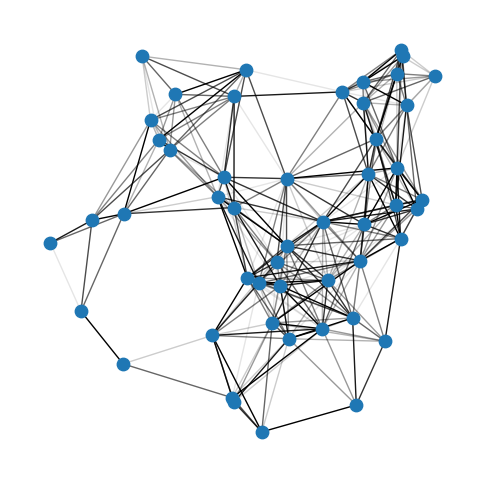

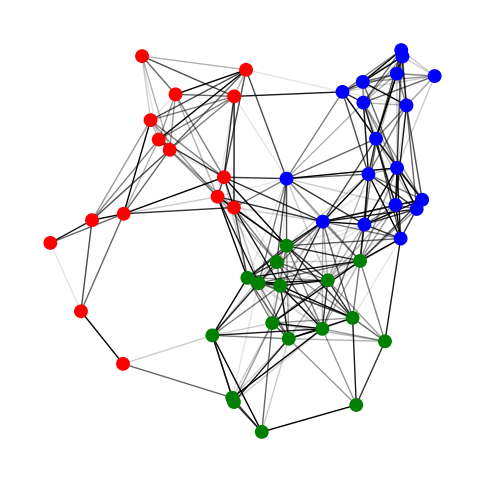

In [15]:
solve_random_graph(0)

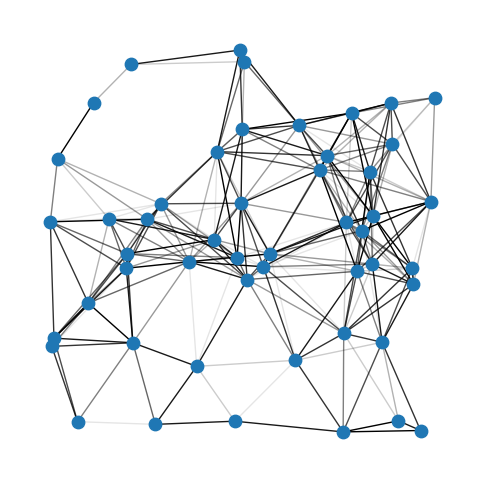

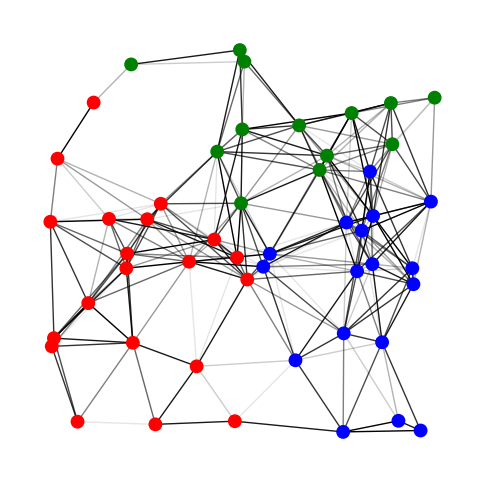

In [16]:
solve_random_graph(1)

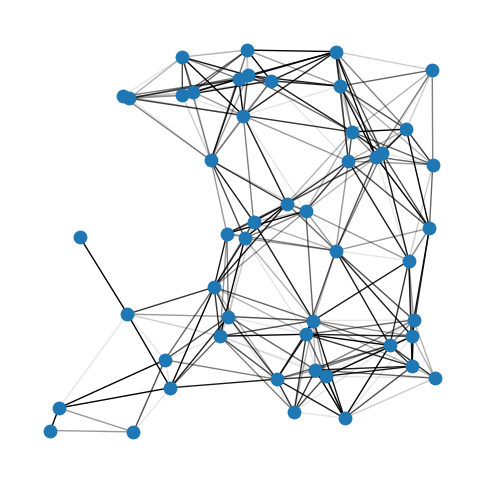

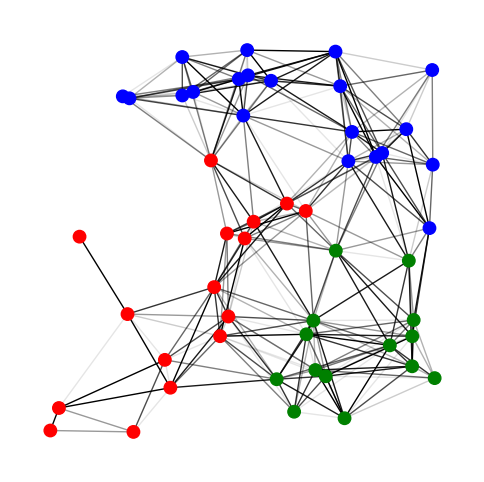

In [17]:
solve_random_graph(2)